Archivos CSV cargados y limpiados exitosamente.

--- ANÁLISIS EXCLUSIVO PARA DATOS DE CALENTAMIENTO ---
Coeficientes calculados para el set 'Heating':
  α_h = 0.003736 °C⁻¹
  β_h = 2285.61 K


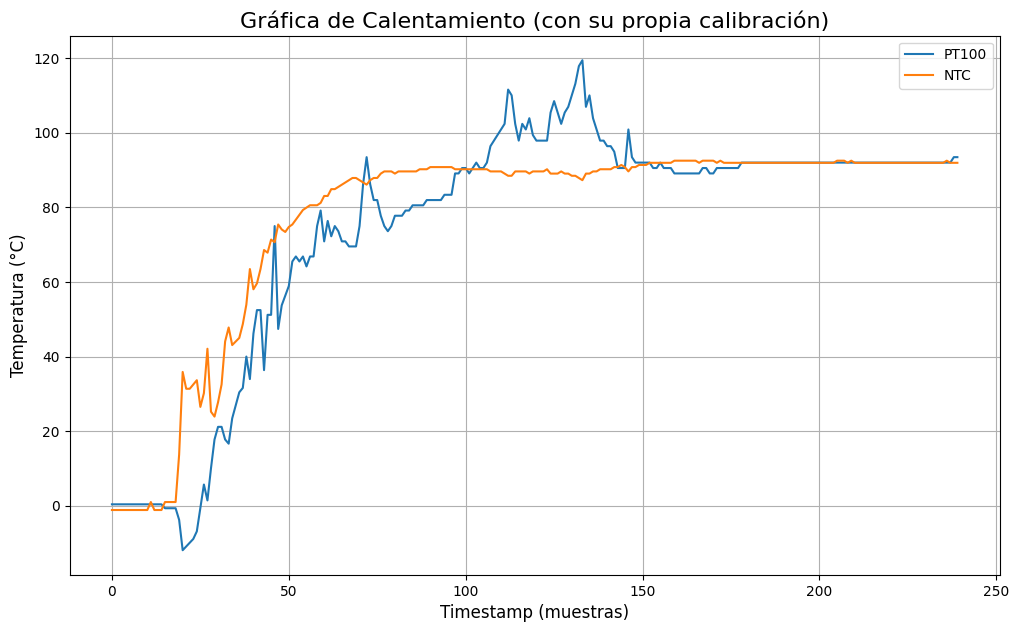


--- ANÁLISIS EXCLUSIVO PARA DATOS DE ENFRIAMIENTO ---
Coeficientes calculados para el set 'Cooling':
  α_c = 0.003301 °C⁻¹
  β_c = 2016.21 K


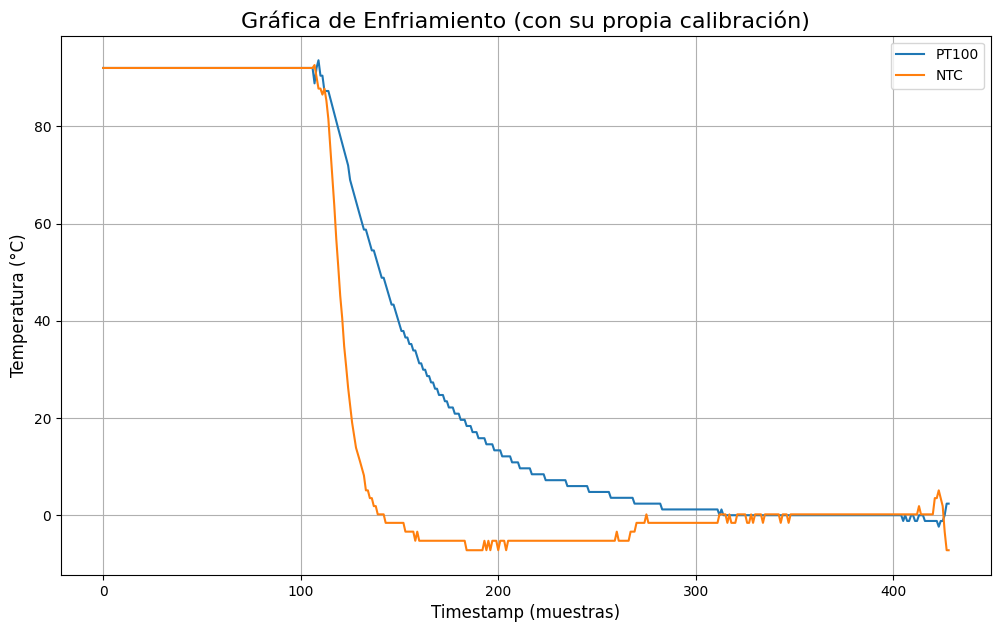

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---
R_FIJA = 100.0
V_IN = 5.0
ADC_MAX = 1023

nombres_columnas = [
    'Timestamp',
    'ADC_PT100', 'Volt_PT100_precalc', 'Res_PT100_precalc',
    'ADC_NTC', 'Volt_NTC_precalc', 'Res_NTC_precalc'
]

try:
    df_heating = pd.read_csv('mixed_heating_1.csv', header=None, names=nombres_columnas)
    df_cooling = pd.read_csv('mixed_cooling_0.csv', header=None, names=nombres_columnas)

    for df in [df_heating, df_cooling]:
        for col in ['Timestamp', 'ADC_PT100', 'ADC_NTC']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=['Timestamp', 'ADC_PT100', 'ADC_NTC'], inplace=True)

    print("Archivos CSV cargados y limpiados exitosamente.")

except FileNotFoundError:
    print("ERROR: Asegúrate de que los archivos CSV estén en la misma carpeta.")
    exit()

def adc_a_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    resistencia = (R_FIJA * voltaje) / (V_IN - voltaje + 1e-9)
    return resistencia

# ==============================================================================
# ANÁLISIS PARA EL EXPERIMENTO DE CALENTAMIENTO (mixed_heating_1.csv)
# ==============================================================================
print("\n--- ANÁLISIS EXCLUSIVO PARA DATOS DE CALENTAMIENTO ---")

# 2.1 Puntos de referencia SOLO de este archivo
slice_frio_h = df_heating.loc[0:20]      # Inicio del calentamiento (0°C)
slice_caliente_h = df_heating.loc[180:220]  # Final del calentamiento (92°C)

R0_PT100_h = adc_a_resistencia(slice_frio_h['ADC_PT100']).mean()
R0_NTC_h = adc_a_resistencia(slice_frio_h['ADC_NTC']).mean()
R92_PT100_h = adc_a_resistencia(slice_caliente_h['ADC_PT100']).mean()
R92_NTC_h = adc_a_resistencia(slice_caliente_h['ADC_NTC']).mean()

# 2.2 Coeficientes calculados SOLO con estos puntos
alpha_h = (R92_PT100_h / R0_PT100_h - 1) / 92.0
beta_h = np.log(R92_NTC_h / R0_NTC_h) / ((1/(92.0+273.15)) - (1/(0.0+273.15)))

print("Coeficientes calculados para el set 'Heating':")
print(f"  α_h = {alpha_h:.6f} °C⁻¹")
print(f"  β_h = {beta_h:.2f} K")

# 2.3 Ecuaciones de calibración a medida para 'Heating'
def temp_pt100_heating(R):
    return ((R / R0_PT100_h) - 1) / alpha_h

def temp_ntc_heating(R):
    T_inv_K = (1/(0.0+273.15)) + (1/beta_h) * np.log(R / R0_NTC_h)
    return (1 / T_inv_K) - 273.15

# 2.4 Aplicar la calibración a medida y graficar
df_heating['Temp_PT100'] = temp_pt100_heating(adc_a_resistencia(df_heating['ADC_PT100']))
df_heating['Temp_NTC'] = temp_ntc_heating(adc_a_resistencia(df_heating['ADC_NTC']))

plt.figure(figsize=(12, 7))
plt.plot(df_heating['Timestamp'], df_heating['Temp_PT100'], label='PT100')
plt.plot(df_heating['Timestamp'], df_heating['Temp_NTC'], label='NTC')
plt.title('Gráfica de Calentamiento (con su propia calibración)', fontsize=16)
plt.xlabel('Timestamp (muestras)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# ==============================================================================
# ANÁLISIS PARA EL EXPERIMENTO DE ENFRIAMIENTO (mixed_cooling_0.csv)
# ==============================================================================
print("\n--- ANÁLISIS EXCLUSIVO PARA DATOS DE ENFRIAMIENTO ---")

# 3.1 Puntos de referencia SOLO de este archivo
slice_caliente_c = df_cooling.loc[0:100]   # Inicio del enfriamiento (92°C)
slice_frio_c = df_cooling.loc[320:400]     # Final del enfriamiento (0°C)

R92_PT100_c = adc_a_resistencia(slice_caliente_c['ADC_PT100']).mean()
R92_NTC_c = adc_a_resistencia(slice_caliente_c['ADC_NTC']).mean()
R0_PT100_c = adc_a_resistencia(slice_frio_c['ADC_PT100']).mean()
R0_NTC_c = adc_a_resistencia(slice_frio_c['ADC_NTC']).mean()

# 3.2 Coeficientes calculados SOLO con estos puntos
alpha_c = (R92_PT100_c / R0_PT100_c - 1) / 92.0
beta_c = np.log(R92_NTC_c / R0_NTC_c) / ((1/(92.0+273.15)) - (1/(0.0+273.15)))

print("Coeficientes calculados para el set 'Cooling':")
print(f"  α_c = {alpha_c:.6f} °C⁻¹")
print(f"  β_c = {beta_c:.2f} K")

# 3.3 Ecuaciones de calibración a medida para 'Cooling'
def temp_pt100_cooling(R):
    return ((R / R0_PT100_c) - 1) / alpha_c

def temp_ntc_cooling(R):
    T_inv_K = (1/(0.0+273.15)) + (1/beta_c) * np.log(R / R0_NTC_c)
    return (1 / T_inv_K) - 273.15

# 3.4 Aplicar la calibración a medida y graficar
df_cooling['Temp_PT100'] = temp_pt100_cooling(adc_a_resistencia(df_cooling['ADC_PT100']))
df_cooling['Temp_NTC'] = temp_ntc_cooling(adc_a_resistencia(df_cooling['ADC_NTC']))

plt.figure(figsize=(12, 7))
plt.plot(df_cooling['Timestamp'], df_cooling['Temp_PT100'], label='PT100')
plt.plot(df_cooling['Timestamp'], df_cooling['Temp_NTC'], label='NTC')
plt.title('Gráfica de Enfriamiento (con su propia calibración)', fontsize=16)
plt.xlabel('Timestamp (muestras)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Archivos CSV cargados y limpiados exitosamente.
Calibraciones independientes aplicadas a cada set de datos.

--- ANÁLISIS DE INERCIA TÉRMICA (90% del cambio total) ---

AVISO: Para PT100 en calentamiento, se usó el método 'de derecha a izquierda' para ignorar el pico inicial.

Resultados para Calentamiento (mixed_heating_1.csv):
  PT100: Tiempo al 90% = 85.00 s
  NTC:   Tiempo al 90% = 51.00 s


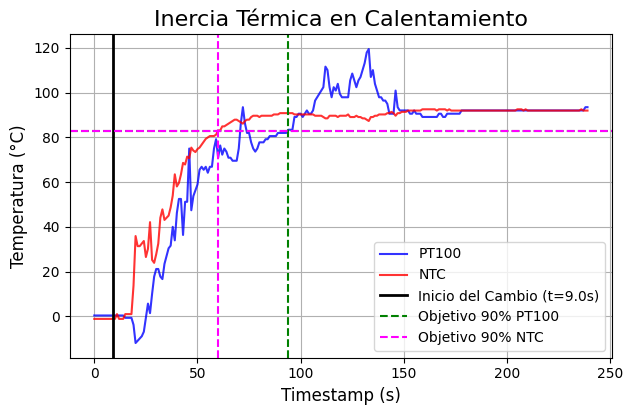


Resultados para Enfriamiento (mixed_cooling_0.csv):
  PT100: Tiempo al 90% = 112.00 s
  NTC:   Tiempo al 90% = 27.00 s


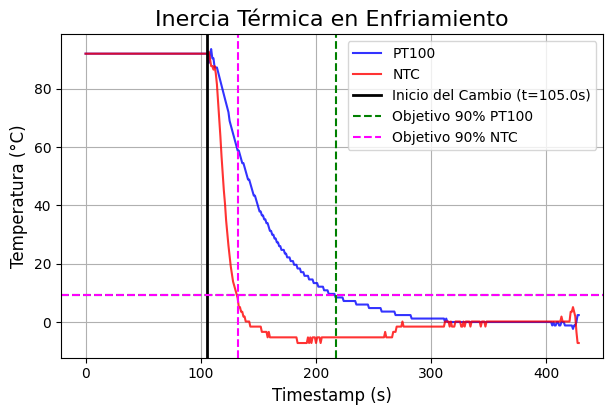

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN Y CARGA DE DATOS ---
R_FIJA = 100.0
V_IN = 5.0
ADC_MAX = 1023

nombres_columnas = [
    'Timestamp',
    'ADC_PT100', 'Volt_PT100_precalc', 'Res_PT100_precalc',
    'ADC_NTC', 'Volt_NTC_precalc', 'Res_NTC_precalc'
]

try:
    df_heating = pd.read_csv('mixed_heating_1.csv', header=None, names=nombres_columnas)
    df_cooling = pd.read_csv('mixed_cooling_0.csv', header=None, names=nombres_columnas)

    for df in [df_heating, df_cooling]:
        for col in ['Timestamp', 'ADC_PT100', 'ADC_NTC']:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=['Timestamp', 'ADC_PT100', 'ADC_NTC'], inplace=True)

    print("Archivos CSV cargados y limpiados exitosamente.")

except FileNotFoundError:
    print("ERROR: Asegúrate de que los archivos CSV estén en la misma carpeta.")
    exit()

def adc_a_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    resistencia = (R_FIJA * voltaje) / (V_IN - voltaje + 1e-9)
    return resistencia

# ==============================================================================
# CALIBRACIÓN INDEPENDIENTE PARA CADA SET DE DATOS
# ==============================================================================

# --- Calibración para Calentamiento ---
slice_frio_h = df_heating.loc[0:20]
slice_caliente_h = df_heating.loc[180:220]
R0_PT100_h = adc_a_resistencia(slice_frio_h['ADC_PT100']).mean()
R0_NTC_h = adc_a_resistencia(slice_frio_h['ADC_NTC']).mean()
R92_PT100_h = adc_a_resistencia(slice_caliente_h['ADC_PT100']).mean()
R92_NTC_h = adc_a_resistencia(slice_caliente_h['ADC_NTC']).mean()
alpha_h = (R92_PT100_h / R0_PT100_h - 1) / 92.0
beta_h = np.log(R92_NTC_h / R0_NTC_h) / ((1/(92.0+273.15)) - (1/(0.0+273.15)))
def temp_pt100_heating(R): return ((R / R0_PT100_h) - 1) / alpha_h
def temp_ntc_heating(R):
    T_inv_K = (1/(0.0+273.15)) + (1/beta_h) * np.log(R / R0_NTC_h)
    return (1 / T_inv_K) - 273.15
df_heating['Temp_PT100'] = temp_pt100_heating(adc_a_resistencia(df_heating['ADC_PT100']))
df_heating['Temp_NTC'] = temp_ntc_heating(adc_a_resistencia(df_heating['ADC_NTC']))

# --- Calibración para Enfriamiento ---
slice_caliente_c = df_cooling.loc[0:100]
slice_frio_c = df_cooling.loc[320:400]
R92_PT100_c = adc_a_resistencia(slice_caliente_c['ADC_PT100']).mean()
R92_NTC_c = adc_a_resistencia(slice_caliente_c['ADC_NTC']).mean()
R0_PT100_c = adc_a_resistencia(slice_frio_c['ADC_PT100']).mean()
R0_NTC_c = adc_a_resistencia(slice_frio_c['ADC_NTC']).mean()
alpha_c = (R92_PT100_c / R0_PT100_c - 1) / 92.0
beta_c = np.log(R92_NTC_c / R0_NTC_c) / ((1/(92.0+273.15)) - (1/(0.0+273.15)))
def temp_pt100_cooling(R): return ((R / R0_PT100_c) - 1) / alpha_c
def temp_ntc_cooling(R):
    T_inv_K = (1/(0.0+273.15)) + (1/beta_c) * np.log(R / R0_NTC_c)
    return (1 / T_inv_K) - 273.15
df_cooling['Temp_PT100'] = temp_pt100_cooling(adc_a_resistencia(df_cooling['ADC_PT100']))
df_cooling['Temp_NTC'] = temp_ntc_cooling(adc_a_resistencia(df_cooling['ADC_NTC']))

print("Calibraciones independientes aplicadas a cada set de datos.")

# ==============================================================================
# ANÁLISIS DE INERCIA TÉRMICA (VERSIÓN FINAL CON CORRECCIÓN DE PICO)
# ==============================================================================
print("\n--- ANÁLISIS DE INERCIA TÉRMICA (90% del cambio total) ---")

# --- Análisis para CALENTAMIENTO (mixed_heating_1.csv) ---

# 1. Definir "Tiempo Cero" en el índice 10
start_time_h = df_heating.loc[10, 'Timestamp']

# 2. Calcular T_inicial y T_final de forma robusta
T_inicial_h_pt100 = df_heating['Temp_PT100'].iloc[0:10].mean()
T_final_h_pt100 = df_heating['Temp_PT100'].iloc[180:220].median() # Usamos mediana para ignorar picos
T_inicial_h_ntc = df_heating['Temp_NTC'].iloc[0:10].mean()
T_final_h_ntc = df_heating['Temp_NTC'].iloc[180:220].mean()

# 3. Calcular objetivo del 90%
target_90_h_pt100 = T_inicial_h_pt100 + 0.9 * (T_final_h_pt100 - T_inicial_h_pt100)
target_90_h_ntc = T_inicial_h_ntc + 0.9 * (T_final_h_ntc - T_inicial_h_ntc)

# 4. Encontrar el tiempo de respuesta

# Para el NTC (Método normal): encuentra la PRIMERA vez que supera el objetivo
end_time_90_h_ntc = df_heating[df_heating['Temp_NTC'] >= target_90_h_ntc]['Timestamp'].iloc[0]
duracion_90_h_ntc = end_time_90_h_ntc - start_time_h

# --- ¡NUEVA LÓGICA PARA EL PT100! ---
# Para el PT100 (Método robusto "de derecha a izquierda"):
# a. Filtramos los datos desde el inicio del cambio
df_transicion_h = df_heating[df_heating['Timestamp'] >= start_time_h]
# b. Encontramos el ÍNDICE del ÚLTIMO punto que está POR DEBAJO del objetivo
last_index_below_target = df_transicion_h[df_transicion_h['Temp_PT100'] < target_90_h_pt100].index[-1]
# c. El cruce verdadero es el punto SIGUIENTE
true_crossing_index = last_index_below_target + 1
end_time_90_h_pt100 = df_heating.loc[true_crossing_index, 'Timestamp']
duracion_90_h_pt100 = end_time_90_h_pt100 - start_time_h
print("\nAVISO: Para PT100 en calentamiento, se usó el método 'de derecha a izquierda' para ignorar el pico inicial.")

print("\nResultados para Calentamiento (mixed_heating_1.csv):")
print(f"  PT100: Tiempo al 90% = {duracion_90_h_pt100:.2f} s")
print(f"  NTC:   Tiempo al 90% = {duracion_90_h_ntc:.2f} s")

# 5. Graficar con colores visibles
plt.figure(figsize=(10*0.7, 6*0.7))
plt.plot(df_heating['Timestamp'], df_heating['Temp_PT100'], label='PT100', color='blue', alpha=0.8)
plt.plot(df_heating['Timestamp'], df_heating['Temp_NTC'], label='NTC', color='red', alpha=0.8)
plt.axvline(x=start_time_h, color='black', linestyle='-', linewidth=2, label=f'Inicio del Cambio (t={start_time_h:.1f}s)')

# Usamos nuevos colores más visibles: 'green' y 'magenta'
plt.axhline(target_90_h_pt100, color='green', linestyle='--', label=f'Objetivo 90% PT100')
plt.axvline(x=end_time_90_h_pt100, color='green', linestyle='--')
plt.axhline(target_90_h_ntc, color='magenta', linestyle='--', label=f'Objetivo 90% NTC')
plt.axvline(x=end_time_90_h_ntc, color='magenta', linestyle='--')

plt.title('Inercia Térmica en Calentamiento', fontsize=16)
plt.xlabel('Timestamp (s)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


# --- Análisis para ENFRIAMIENTO (mixed_cooling_0.csv) ---

# (Este bloque no necesita la lógica especial, se mantiene como antes)
start_time_c = df_cooling.loc[106, 'Timestamp']
T_inicial_c_pt100 = df_cooling['Temp_PT100'].iloc[0:106].mean()
T_final_c_pt100 = df_cooling['Temp_PT100'].iloc[320:400].mean()
T_inicial_c_ntc = df_cooling['Temp_NTC'].iloc[0:106].mean()
T_final_c_ntc = df_cooling['Temp_NTC'].iloc[320:400].mean()
target_90_c_pt100 = T_inicial_c_pt100 - 0.9 * (T_inicial_c_pt100 - T_final_c_pt100)
end_time_90_c_pt100 = df_cooling[df_cooling['Temp_PT100'] <= target_90_c_pt100]['Timestamp'].iloc[0]
target_90_c_ntc = T_inicial_c_ntc - 0.9 * (T_inicial_c_ntc - T_final_c_ntc)
end_time_90_c_ntc = df_cooling[df_cooling['Temp_NTC'] <= target_90_c_ntc]['Timestamp'].iloc[0]
duracion_90_c_pt100 = end_time_90_c_pt100 - start_time_c
duracion_90_c_ntc = end_time_90_c_ntc - start_time_c

print("\nResultados para Enfriamiento (mixed_cooling_0.csv):")
print(f"  PT100: Tiempo al 90% = {duracion_90_c_pt100:.2f} s")
print(f"  NTC:   Tiempo al 90% = {duracion_90_c_ntc:.2f} s")

plt.figure(figsize=(10*0.7, 6*0.7))
plt.plot(df_cooling['Timestamp'], df_cooling['Temp_PT100'], label='PT100', color='blue', alpha=0.8)
plt.plot(df_cooling['Timestamp'], df_cooling['Temp_NTC'], label='NTC', color='red', alpha=0.8)
plt.axvline(x=start_time_c, color='black', linestyle='-', linewidth=2, label=f'Inicio del Cambio (t={start_time_c:.1f}s)')
plt.axhline(target_90_c_pt100, color='green', linestyle='--', label=f'Objetivo 90% PT100')
plt.axvline(x=end_time_90_c_pt100, color='green', linestyle='--')
plt.axhline(target_90_c_ntc, color='magenta', linestyle='--', label=f'Objetivo 90% NTC')
plt.axvline(x=end_time_90_c_ntc, color='magenta', linestyle='--')
plt.title('Inercia Térmica en Enfriamiento', fontsize=16)
plt.xlabel('Timestamp (s)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

Archivo de calibración 'mixed_cooling_0.csv' cargado.
Funciones de calibración de 'cooling' listas.

Archivo 'mixedBoiling1repro.csv' cargado y temperaturas calculadas.

--- Análisis de Reproducibilidad para el sensor: PT100 ---
1. Referencia Global (todos los picos juntos):
   - Promedio Total: 92.52 °C
   - Desviación Estándar Total (ruido): 3.70 °C

2. Análisis Intra-Ciclo (estabilidad de cada pico):
   - Pico 1 (20-30): Promedio = 87.13 °C, Desv. Est. = 1.48 °C
   - Pico 2 (80-105): Promedio = 94.33 °C, Desv. Est. = 1.03 °C
   - Pico 3 (160-190): Promedio = 95.77 °C, Desv. Est. = 1.06 °C
   - Pico 4 (250-270): Promedio = 88.31 °C, Desv. Est. = 1.04 °C

3. Análisis Inter-Ciclo (qué tan parecidos son los picos entre sí):
   - Lista de promedios de cada pico: ['87.13', '94.33', '95.77', '88.31']
   - ⭐ Desviación Estándar de los Promedios (REPRODUCIBILIDAD): 3.724 °C



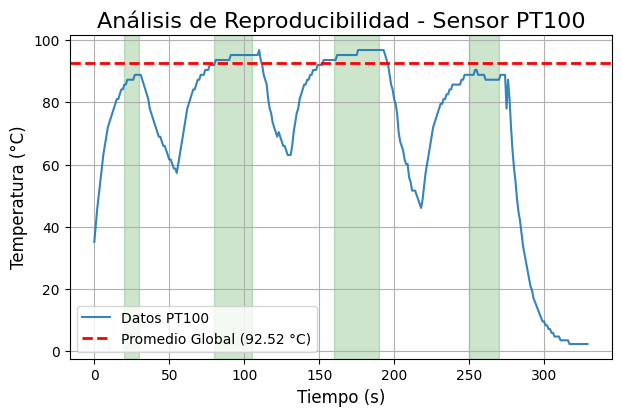

--- Análisis de Reproducibilidad para el sensor: NTC ---
1. Referencia Global (todos los picos juntos):
   - Promedio Total: 90.90 °C
   - Desviación Estándar Total (ruido): 1.40 °C

2. Análisis Intra-Ciclo (estabilidad de cada pico):
   - Pico 1 (20-30): Promedio = 91.13 °C, Desv. Est. = 0.31 °C
   - Pico 2 (80-105): Promedio = 90.61 °C, Desv. Est. = 0.28 °C
   - Pico 3 (160-190): Promedio = 89.57 °C, Desv. Est. = 0.11 °C
   - Pico 4 (250-270): Promedio = 93.11 °C, Desv. Est. = 0.71 °C

3. Análisis Inter-Ciclo (qué tan parecidos son los picos entre sí):
   - Lista de promedios de cada pico: ['91.13', '90.61', '89.57', '93.11']
   - ⭐ Desviación Estándar de los Promedios (REPRODUCIBILIDAD): 1.285 °C



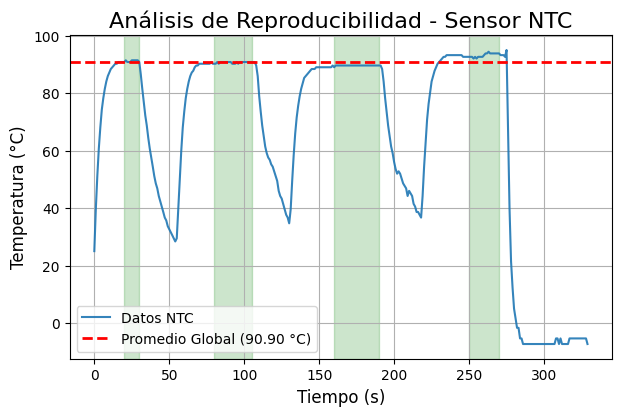

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CONFIGURACIÓN Y RE-ESTABLECIMIENTO DE LA CALIBRACIÓN "COOLING" ---
R_FIJA = 100.0
V_IN = 5.0
ADC_MAX = 1023

nombres_columnas = [
    'Timestamp',
    'ADC_PT100', 'Volt_PT100_precalc', 'Res_PT100_precalc',
    'ADC_NTC', 'Volt_NTC_precalc', 'Res_NTC_precalc'
]

try:
    df_cooling_cal = pd.read_csv('mixed_cooling_0.csv', header=None, names=nombres_columnas)
    for col in ['Timestamp', 'ADC_PT100', 'ADC_NTC']:
        df_cooling_cal[col] = pd.to_numeric(df_cooling_cal[col], errors='coerce')
    df_cooling_cal.dropna(subset=['Timestamp', 'ADC_PT100', 'ADC_NTC'], inplace=True)
    print("Archivo de calibración 'mixed_cooling_0.csv' cargado.")
except FileNotFoundError:
    print("ERROR: No se encontró el archivo de calibración 'mixed_cooling_0.csv'.")
    exit()

def adc_a_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    resistencia = (R_FIJA * voltaje) / (V_IN - voltaje + 1e-9)
    return resistencia

slice_caliente_c = df_cooling_cal.loc[0:100]
slice_frio_c = df_cooling_cal.loc[320:400]
R92_PT100_c = adc_a_resistencia(slice_caliente_c['ADC_PT100']).mean()
R92_NTC_c = adc_a_resistencia(slice_caliente_c['ADC_NTC']).mean()
R0_PT100_c = adc_a_resistencia(slice_frio_c['ADC_PT100']).mean()
R0_NTC_c = adc_a_resistencia(slice_frio_c['ADC_NTC']).mean()
alpha_c = (R92_PT100_c / R0_PT100_c - 1) / 92.0
beta_c = np.log(R92_NTC_c / R0_NTC_c) / ((1/(92.0+273.15)) - (1/(0.0+273.15)))
def temp_pt100_cooling(R): return ((R / R0_PT100_c) - 1) / alpha_c
def temp_ntc_cooling(R):
    T_inv_K = (1/(0.0+273.15)) + (1/beta_c) * np.log(R / R0_NTC_c)
    return (1 / T_inv_K) - 273.15
print("Funciones de calibración de 'cooling' listas.\n")

# --- 2. ANÁLISIS DE REPRODUCIBILIDAD ---

archivo_repro = "mixedBoiling1repro.csv"
try:
    df_repro = pd.read_csv(archivo_repro, header=None, names=nombres_columnas)
    for col in ['Timestamp', 'ADC_PT100', 'ADC_NTC']:
        df_repro[col] = pd.to_numeric(df_repro[col], errors='coerce')
    df_repro.dropna(subset=['Timestamp', 'ADC_PT100', 'ADC_NTC'], inplace=True)

    df_repro['Temp_PT100'] = temp_pt100_cooling(adc_a_resistencia(df_repro['ADC_PT100']))
    df_repro['Temp_NTC'] = temp_ntc_cooling(adc_a_resistencia(df_repro['ADC_NTC']))
    print(f"Archivo '{archivo_repro}' cargado y temperaturas calculadas.\n")
except FileNotFoundError:
    print(f"¡ERROR! No se encontró el archivo '{archivo_repro}'.")
    exit()

# Intervalos donde el sensor está DENTRO del agua caliente
intervalos_hot = [(20, 30), (80, 105), (160, 190), (250, 270)]

for sensor in ['PT100', 'NTC']:
    print(f"--- Análisis de Reproducibilidad para el sensor: {sensor} ---")

    # 1. Establecer la Temperatura de Referencia Global
    datos_completos_hot = pd.concat([df_repro.loc[start:end][f'Temp_{sensor}'] for start, end in intervalos_hot])
    promedio_global = datos_completos_hot.mean()
    std_global = datos_completos_hot.std()
    print(f"1. Referencia Global (todos los picos juntos):")
    print(f"   - Promedio Total: {promedio_global:.2f} °C")
    print(f"   - Desviación Estándar Total (ruido): {std_global:.2f} °C\n")

    # 2. Análisis Intra-Ciclo (cada pico por separado)
    promedios_de_picos = []
    print("2. Análisis Intra-Ciclo (estabilidad de cada pico):")
    for i, (start, end) in enumerate(intervalos_hot):
        pico = df_repro.loc[start:end][f'Temp_{sensor}']
        promedio_pico = pico.mean()
        std_pico = pico.std()
        promedios_de_picos.append(promedio_pico)
        print(f"   - Pico {i+1} ({start}-{end}): Promedio = {promedio_pico:.2f} °C, Desv. Est. = {std_pico:.2f} °C")

    # 3. Análisis Inter-Ciclo (la reproducibilidad)
    promedios_de_picos = np.array(promedios_de_picos)
    std_de_promedios = np.std(promedios_de_picos)
    print("\n3. Análisis Inter-Ciclo (qué tan parecidos son los picos entre sí):")
    print(f"   - Lista de promedios de cada pico: {[f'{p:.2f}' for p in promedios_de_picos]}")
    print(f"   - ⭐ Desviación Estándar de los Promedios (REPRODUCIBILIDAD): {std_de_promedios:.3f} °C\n")

    # 4. Graficar
    plt.figure(figsize=(10*0.7, 6*0.7))
    plt.plot(df_repro['Timestamp'], df_repro[f'Temp_{sensor}'], label=f'Datos {sensor}', alpha=0.9)
    # Dibuja la recta de referencia global
    plt.axhline(y=promedio_global, color='red', linestyle='--', linewidth=2, label=f'Promedio Global ({promedio_global:.2f} °C)')
    # Sombrea las regiones de análisis
    for start, end in intervalos_hot:
        plt.axvspan(start, end, color='green', alpha=0.2, label='_nolegend_') # Usamos _nolegend_ para que no se repita en la leyenda

    plt.title(f"Análisis de Reproducibilidad - Sensor {sensor}", fontsize=16)
    plt.xlabel('Tiempo (s)', fontsize=12)
    plt.ylabel('Temperatura (°C)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

Archivo de calibración 'mixed_cooling_0.csv' cargado exitosamente.

SECCIÓN A: DATOS PARA CARACTERIZACIÓN Y RESOLUCIÓN

--- A.1 Puntos de Referencia ---
Valores de Resistencia de Referencia (con error instrumental propagado):
  R₀ (PT100) a 0.0°C:   (107.93 ± 0.42) Ω
  R₉₂ (PT100) a 92.0°C: (140.71 ± 0.57) Ω
  R₀ (NTC) a 0.0°C:     (4571.87 ± 213.27) Ω
  R₉₂ (NTC) a 92.0°C:   (711.90 ± 6.44) Ω

--- A.2 Termopar ---
Ecuación T_real(°C) = (1.0455 ± 0.0168) * T_medida + (0.0000 ± 1.0455)

--- A.3 Sensor PT-100 ---
Coeficiente Alfa (α): 0.003301 ± 0.000094 °C⁻¹


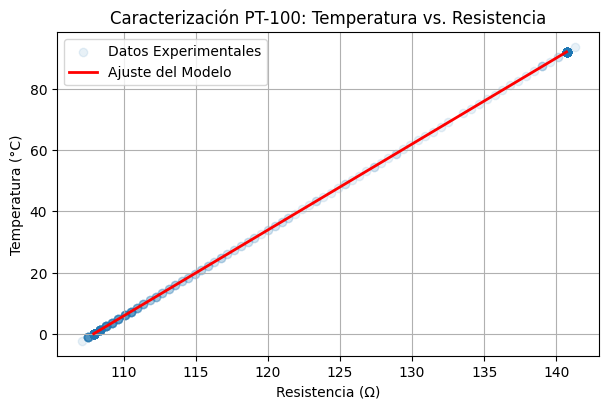


--- A.4 Termistor NTC ---
Coeficiente Beta (β): 2016.21 ± 61.49 K


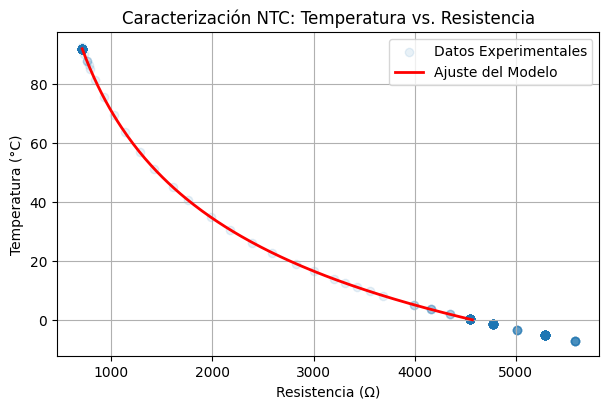


--- A.5 Resolución del Sistema (calculada a 0°C) ---
  Resolución PT100 a 0°C: 1.1850 °C
  Resolución NTC a 0°C:   1.7253 °C


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 0. CONFIGURACIÓN GLOBAL Y FUNCIONES ---
R_FIJA = 100.0
V_IN = 5.0
ADC_MAX = 1023
UNCERT_ADC = 1.0 # Incertidumbre instrumental de la lectura binaria (±1 bit)

# Función para convertir ADC a Resistencia
def adc_a_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    resistencia = (R_FIJA * voltaje) / (V_IN - voltaje + 1e-9)
    return resistencia

# Función para propagar el error del ADC a la Resistencia
def propagar_error_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    dV_dADC = V_IN / ADC_MAX
    dR_dV = (R_FIJA * V_IN) / ((V_IN - voltaje + 1e-9)**2)
    return np.abs(dR_dV) * dV_dADC * UNCERT_ADC

# --- 1. CARGA DE DATOS ---
try:
    # Para la calibración, usaremos el archivo 'cooling' que tiene puntos estables en ambos extremos
    df_cal = pd.read_csv('mixed_cooling_0.csv', header=None,
                         names=['Timestamp', 'ADC_PT100', 'Volt_PT100_precalc', 'Res_PT100_precalc',
                                'ADC_NTC', 'Volt_NTC_precalc', 'Res_NTC_precalc'])

    for col in ['Timestamp', 'ADC_PT100', 'ADC_NTC']:
        df_cal[col] = pd.to_numeric(df_cal[col], errors='coerce')
    df_cal.dropna(subset=['Timestamp', 'ADC_PT100', 'ADC_NTC'], inplace=True)

    print("Archivo de calibración 'mixed_cooling_0.csv' cargado exitosamente.")
except Exception as e:
    print(f"ERROR al cargar archivos: {e}")
    exit()

# ==============================================================================
# SECCIÓN A: CARACTERIZACIÓN Y RESOLUCIÓN
# ==============================================================================
print("\n" + "="*60)
print("SECCIÓN A: DATOS PARA CARACTERIZACIÓN Y RESOLUCIÓN")
print("="*60)

# --- A.1 Puntos de Referencia con Incertidumbre ---
print("\n--- A.1 Puntos de Referencia ---")

# Definir temperaturas de referencia y su incertidumbre
T0_C = 0.0
T92_C = 92.0
dT_C = 1.0 # Incertidumbre de ±1 °C para la temperatura de referencia

# Extraer datos de las zonas estables
slice_caliente = df_cal.loc[0:100]
slice_frio = df_cal.loc[320:400]

# Calcular resistencias promedio y su incertidumbre instrumental propagada
R92_pt100 = adc_a_resistencia(slice_caliente['ADC_PT100']).mean()
dR92_pt100 = propagar_error_resistencia(slice_caliente['ADC_PT100'].mean())
R0_pt100 = adc_a_resistencia(slice_frio['ADC_PT100']).mean()
dR0_pt100 = propagar_error_resistencia(slice_frio['ADC_PT100'].mean())

R92_ntc = adc_a_resistencia(slice_caliente['ADC_NTC']).mean()
dR92_ntc = propagar_error_resistencia(slice_caliente['ADC_NTC'].mean())
R0_ntc = adc_a_resistencia(slice_frio['ADC_NTC']).mean()
dR0_ntc = propagar_error_resistencia(slice_frio['ADC_NTC'].mean())

print("Valores de Resistencia de Referencia (con error instrumental propagado):")
print(f"  R₀ (PT100) a {T0_C}°C:   ({R0_pt100:.2f} ± {dR0_pt100:.2f}) Ω")
print(f"  R₉₂ (PT100) a {T92_C}°C: ({R92_pt100:.2f} ± {dR92_pt100:.2f}) Ω")
print(f"  R₀ (NTC) a {T0_C}°C:     ({R0_ntc:.2f} ± {dR0_ntc:.2f}) Ω")
print(f"  R₉₂ (NTC) a {T92_C}°C:   ({R92_ntc:.2f} ± {dR92_ntc:.2f}) Ω")


# --- A.2 Termopar ---
print("\n--- A.2 Termopar ---")
# Puntos de datos: (x, y) donde x=T_medida, y=T_referencia
x1, y1 = 0, 0
x2, y2 = 88, 92
dx = 1.0 # Incertidumbre en T_medida
m = (y2 - y1) / (x2 - x1)
b = y1 - m * x1
dm = np.sqrt(((-(y2-y1)/(x2-x1)**2)*dx)**2 + (((y2-y1)/(x2-x1)**2)*dx)**2)
db = np.sqrt(((-x1)*dm)**2 + ((-m)*dx)**2)
print(f"Ecuación T_real(°C) = ({m:.4f} ± {dm:.4f}) * T_medida + ({b:.4f} ± {db:.4f})")


# --- A.3 PT-100: Cálculo de α y Gráfica ---
print("\n--- A.3 Sensor PT-100 ---")
# Despeje algebraico de α
alpha = (R92_pt100 / R0_pt100 - 1) / (T92_C - T0_C)

# Propagación de error para α = f(R₉₂, R₀, T₉₂, T₀)
d_alpha_dR92_sq = (1 / (R0_pt100 * (T92_C - T0_C)))**2 * dR92_pt100**2
d_alpha_dR0_sq  = (-R92_pt100 / (R0_pt100**2 * (T92_C - T0_C)))**2 * dR0_pt100**2
d_alpha_dT92_sq = (-(R92_pt100/R0_pt100 - 1) / (T92_C - T0_C)**2)**2 * dT_C**2
d_alpha_dT0_sq  = ((R92_pt100/R0_pt100 - 1) / (T92_C - T0_C)**2)**2 * dT_C**2
d_alpha = np.sqrt(d_alpha_dR92_sq + d_alpha_dR0_sq + d_alpha_dT92_sq + d_alpha_dT0_sq)

print(f"Coeficiente Alfa (α): {alpha:.6f} ± {d_alpha:.6f} °C⁻¹")

def temp_pt100(R): return T0_C + (1/alpha) * (R/R0_pt100 - 1)

df_cal['Temp_PT100'] = temp_pt100(adc_a_resistencia(df_cal['ADC_PT100']))

plt.figure("Caracterización PT-100", figsize=(10*0.7, 6*0.7))
plt.scatter(adc_a_resistencia(df_cal['ADC_PT100']), df_cal['Temp_PT100'], alpha=0.1, label='Datos Experimentales')
R_plot = np.linspace(R0_pt100, R92_pt100, 100)
plt.plot(R_plot, temp_pt100(R_plot), color='red', linewidth=2, label='Ajuste del Modelo')
plt.title('Caracterización PT-100: Temperatura vs. Resistencia')
plt.xlabel('Resistencia (Ω)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# --- A.4 Termistor NTC: Cálculo de β y Gráfica ---
print("\n--- A.4 Termistor NTC ---")
T0_K, T92_K = T0_C + 273.15, T92_C + 273.15
dT_K = dT_C # Una incertidumbre de 1°C es igual a 1K
termino_T = (1/T92_K) - (1/T0_K)

# Despeje algebraico de β
beta = np.log(R92_ntc / R0_ntc) / termino_T

# Propagación de error para β = f(R₉₂, R₀, T₉₂, T₀)
d_beta_dR92_sq = (1 / (R92_ntc * termino_T))**2 * dR92_ntc**2
d_beta_dR0_sq  = (-1 / (R0_ntc * termino_T))**2 * dR0_ntc**2
d_beta_dT92_sq = (np.log(R92_ntc/R0_ntc) / (termino_T**2 * T92_K**2))**2 * dT_K**2
d_beta_dT0_sq  = (-np.log(R92_ntc/R0_ntc) / (termino_T**2 * T0_K**2))**2 * dT_K**2
d_beta = np.sqrt(d_beta_dR92_sq + d_beta_dR0_sq + d_beta_dT92_sq + d_beta_dT0_sq)

print(f"Coeficiente Beta (β): {beta:.2f} ± {d_beta:.2f} K")

def temp_ntc(R):
    # Evita errores con log(<=0)
    if R <= 0: return np.nan
    T_inv_K = (1/T0_K) + (1/beta) * np.log(R / R0_ntc)
    return (1/T_inv_K) - 273.15

df_cal['Temp_NTC'] = adc_a_resistencia(df_cal['ADC_NTC']).apply(temp_ntc)

plt.figure("Caracterización NTC", figsize=(10*0.7, 6*0.7))
plt.scatter(adc_a_resistencia(df_cal['ADC_NTC']), df_cal['Temp_NTC'], alpha=0.1, label='Datos Experimentales')
R_plot_ntc = np.linspace(R92_ntc, R0_ntc, 200)
plt.plot(R_plot_ntc, [temp_ntc(r) for r in R_plot_ntc], color='red', linewidth=2, label='Ajuste del Modelo')
plt.title('Caracterización NTC: Temperatura vs. Resistencia')
plt.xlabel('Resistencia (Ω)')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.grid(True)
plt.show()

# --- A.5 Cálculo de Resolución ---
print("\n--- A.5 Resolución del Sistema (calculada a 0°C) ---")
delta_v_min = V_IN / (ADC_MAX + 1)

V_out_pt100_0c = V_IN * R0_pt100 / (R_FIJA + R0_pt100)
dR_dV_pt100 = (R_FIJA * V_IN) / (V_IN - V_out_pt100_0c)**2
dT_dR_pt100 = 1 / (alpha * R0_pt100)
resolucion_pt100 = abs(dT_dR_pt100 * dR_dV_pt100 * delta_v_min)

V_out_ntc_0c = V_IN * R0_ntc / (R_FIJA + R0_ntc)
dR_dV_ntc = (R_FIJA * V_IN) / (V_IN - V_out_ntc_0c)**2
dT_dR_ntc = abs(-(T0_K**2) / (beta * R0_ntc))
resolucion_ntc = abs(dT_dR_ntc * dR_dV_ntc * delta_v_min)

print(f"  Resolución PT100 a 0°C: {resolucion_pt100:.4f} °C")
print(f"  Resolución NTC a 0°C:   {resolucion_ntc:.4f} °C")


--- LINEALIDAD PT100 ---
  R² = 1.000000
  Pendiente = 0.3563 Ω/°C
  Intercepto = 107.93 Ω


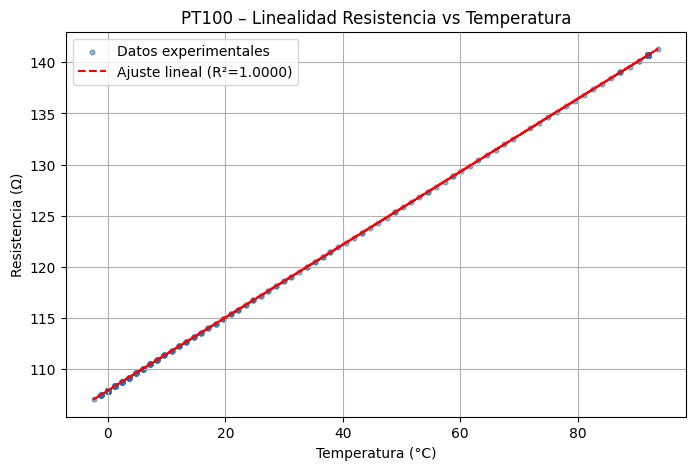


--- LINEALIDAD NTC ---
  R² = 0.976285
  Pendiente = -44.8131 Ω/°C
  Intercepto = 4751.78 Ω


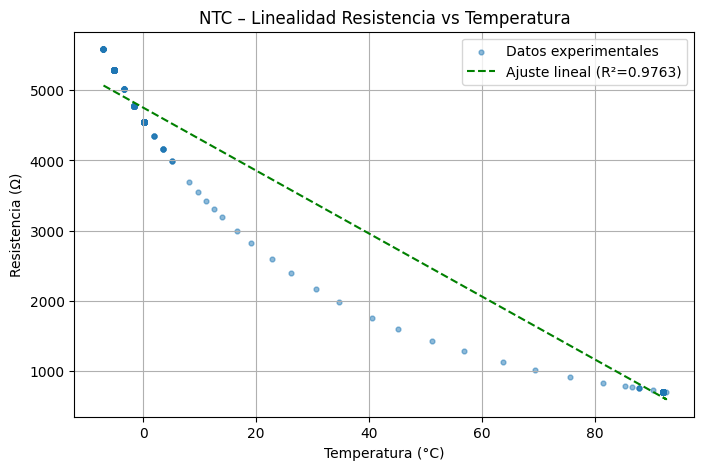

In [ ]:
# ==============================================================================
# SECCIÓN B: EVALUACIÓN DE LINEALIDAD POR SENSOR (R vs T)
# ==============================================================================

from sklearn.metrics import r2_score

# --- PT100 ---
coef_PT100 = np.polyfit(df_cal['Temp_PT100'], df_cal['R_PT100'], 1)
fit_PT100 = np.polyval(coef_PT100, df_cal['Temp_PT100'])
r2_PT100 = r2_score(df_cal['R_PT100'], fit_PT100)

print("\n--- LINEALIDAD PT100 ---")
print(f"  R² = {r2_PT100:.6f}")
print(f"  Pendiente = {coef_PT100[0]:.4f} Ω/°C")
print(f"  Intercepto = {coef_PT100[1]:.2f} Ω")

plt.figure("Linealidad PT100", figsize=(8,5))
plt.scatter(df_cal['Temp_PT100'], df_cal['R_PT100'], s=12, alpha=0.5, label='Datos experimentales')
plt.plot(df_cal['Temp_PT100'], fit_PT100, 'r--', label=f'Ajuste lineal (R²={r2_PT100:.4f})')
plt.title('PT100 – Linealidad Resistencia vs Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Resistencia (Ω)')
plt.legend()
plt.grid(True)
plt.show()


# --- NTC ---
coef_NTC = np.polyfit(df_cal['Temp_NTC'], df_cal['R_NTC'], 1)
fit_NTC = np.polyval(coef_NTC, df_cal['Temp_NTC'])
r2_NTC = r2_score(df_cal['R_NTC'], fit_NTC)

print("\n--- LINEALIDAD NTC ---")
print(f"  R² = {r2_NTC:.6f}")
print(f"  Pendiente = {coef_NTC[0]:.4f} Ω/°C")
print(f"  Intercepto = {coef_NTC[1]:.2f} Ω")

plt.figure("Linealidad NTC", figsize=(8,5))
plt.scatter(df_cal['Temp_NTC'], df_cal['R_NTC'], s=12, alpha=0.5, label='Datos experimentales')
plt.plot(df_cal['Temp_NTC'], fit_NTC, 'g--', label=f'Ajuste lineal (R²={r2_NTC:.4f})')
plt.title('NTC – Linealidad Resistencia vs Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Resistencia (Ω)')
plt.legend()
plt.grid(True)
plt.show()


Archivo cargado correctamente.

Columnas convertidas a valores numéricos.

⚠️ No se encontró una columna válida de termopar. Se usarán T_min=0.0 °C y T_max=92.0 °C



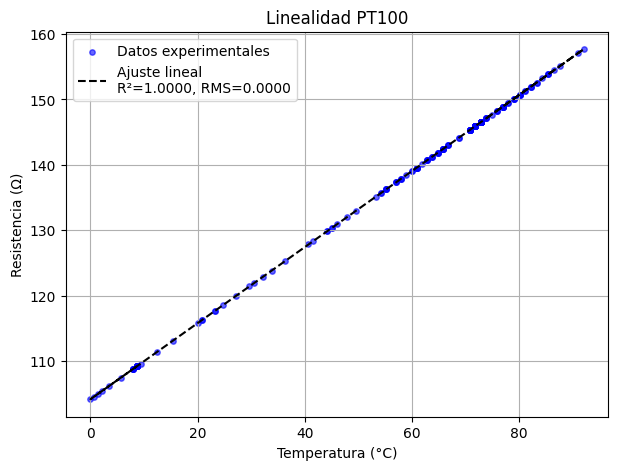

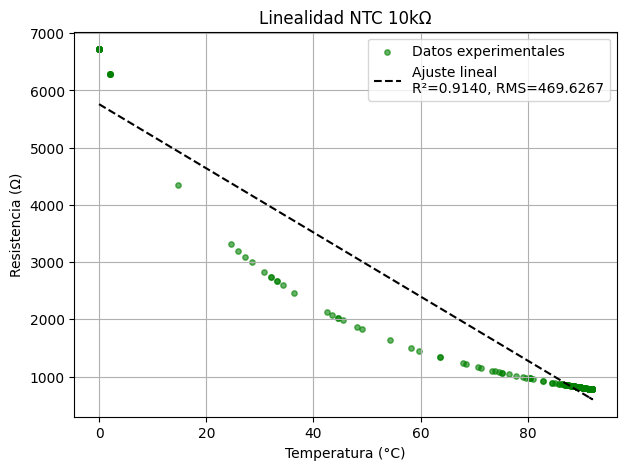

=== RESULTADOS DE LINEALIDAD ===
PT100 → R² = 1.00000,  RMS = 0.00000 Ω
NTC   → R² = 0.91404, RMS = 469.62669 Ω


In [ ]:
# ================================================================
# ANÁLISIS COMPLETO: CALIBRACIÓN Y LINEALIDAD PT100 y NTC (ROBUSTO)
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# --- CONFIGURACIÓN ---
R_FIJA = 100.0
V_IN = 5.0
ADC_MAX = 1023

# --- CARGA DE ARCHIVOS ---
nombres_columnas = [
    'Timestamp',
    'ADC_PT100', 'Volt_PT100_precalc', 'Res_PT100_precalc',
    'ADC_NTC', 'Volt_NTC_precalc', 'Res_NTC_precalc',
    'T_termo'  # Si no existe esta columna, se usará 0–92 °C
]

try:
    df_cal = pd.read_csv('mixed_heating_1.csv', header=None, names=nombres_columnas)
    print("Archivo cargado correctamente.\n")
except FileNotFoundError:
    print("❌ ERROR: No se encontró el archivo 'mixed_heating_1.csv'.")
    raise SystemExit

# --- CONVERTIR COLUMNAS A NUMÉRICAS ---
cols_numericas = ['ADC_PT100', 'ADC_NTC', 'T_termo']
for c in cols_numericas:
    if c in df_cal.columns:
        df_cal[c] = pd.to_numeric(df_cal[c], errors='coerce')

df_cal.dropna(subset=['ADC_PT100', 'ADC_NTC'], inplace=True)
print("Columnas convertidas a valores numéricos.\n")

# --- CONVERSIÓN ADC → RESISTENCIA ---
def adc_a_resistencia(adc_reading):
    voltaje = (adc_reading / ADC_MAX) * V_IN
    resistencia = (R_FIJA * voltaje) / (V_IN - voltaje + 1e-9)
    return resistencia

df_cal['Res_PT100'] = adc_a_resistencia(df_cal['ADC_PT100'])
df_cal['Res_NTC'] = adc_a_resistencia(df_cal['ADC_NTC'])

# --- DETERMINAR RANGO DE TEMPERATURAS ---
if 'T_termo' in df_cal.columns and df_cal['T_termo'].notna().any():
    T_min, T_max = df_cal['T_termo'].min(), df_cal['T_termo'].max()
    print(f"Temperaturas del termopar: mín = {T_min:.2f} °C, máx = {T_max:.2f} °C\n")
else:
    T_min, T_max = 0.0, 92.0
    print(f"⚠️ No se encontró una columna válida de termopar. Se usarán T_min={T_min} °C y T_max={T_max} °C\n")

# --- CORRECCIÓN LINEAL PARA COINCIDIR CON TERMOPAR ---
def corregir_rango(T_sensor):
    return (T_sensor - T_sensor.min()) * (T_max - T_min) / (T_sensor.max() - T_sensor.min()) + T_min

# --- ECUACIONES DE TEMPERATURA ---
R0_PT100 = df_cal['Res_PT100'].iloc[0]
R92_PT100 = df_cal['Res_PT100'].iloc[-1]
alpha_PT100 = (R92_PT100 / R0_PT100 - 1) / (T_max - T_min)

R0_NTC = df_cal['Res_NTC'].iloc[0]
R92_NTC = df_cal['Res_NTC'].iloc[-1]
beta_NTC = np.log(R92_NTC / R0_NTC) / ((1/(T_max+273.15)) - (1/(T_min+273.15)))

def temp_pt100(R):
    return ((R / R0_PT100) - 1) / alpha_PT100 + T_min

def temp_ntc(R):
    T_inv = (1/(T_min+273.15)) + (1/beta_NTC) * np.log(R / R0_NTC)
    return (1 / T_inv) - 273.15

# --- CALCULO DE TEMPERATURA Y CORRECCIÓN ---
df_cal['T_PT100_raw'] = temp_pt100(df_cal['Res_PT100'])
df_cal['T_NTC_raw'] = temp_ntc(df_cal['Res_NTC'])

df_cal['T_PT100_corr'] = corregir_rango(df_cal['T_PT100_raw'])
df_cal['T_NTC_corr'] = corregir_rango(df_cal['T_NTC_raw'])

# ================================================================
#                   ANÁLISIS DE LINEALIDAD
# ================================================================
def analizar_linealidad(temp, res, nombre, color):
    coef = np.polyfit(temp, res, 1)
    fit = np.polyval(coef, temp)
    r2 = r2_score(res, fit)
    rms = np.sqrt(mean_squared_error(res, fit))

    plt.figure(figsize=(7,5))
    plt.scatter(temp, res, s=15, label='Datos experimentales', color=color, alpha=0.6)
    plt.plot(temp, fit, 'k--', label=f'Ajuste lineal\nR²={r2:.4f}, RMS={rms:.4f}')
    plt.title(f'Linealidad {nombre}')
    plt.xlabel('Temperatura (°C)')
    plt.ylabel('Resistencia (Ω)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return r2, rms

# --- PT100 ---
r2_pt, rms_pt = analizar_linealidad(df_cal['T_PT100_corr'], df_cal['Res_PT100'], 'PT100', 'blue')

# --- NTC ---
r2_ntc, rms_ntc = analizar_linealidad(df_cal['T_NTC_corr'], df_cal['Res_NTC'], 'NTC 10kΩ', 'green')

# ================================================================
#                   RESULTADOS NUMÉRICOS
# ================================================================
print("=== RESULTADOS DE LINEALIDAD ===")
print(f"PT100 → R² = {r2_pt:.5f},  RMS = {rms_pt:.5f} Ω")
print(f"NTC   → R² = {r2_ntc:.5f}, RMS = {rms_ntc:.5f} Ω")
